In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
import torch
import re
import statistics
import ast
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

In [2]:
df = pd.read_excel("/home/student/HallucinationsLLM/data/team5_clean_dataset.xlsx", index_col=0)

In [3]:
def count_brackets(string):
    counter = 0
    for c in string: 
        if c == "[":
            counter += 1 
    return counter

def clean_text(text):
    # Remove specific substrings
    text = re.sub(r'<0x0A>', ' ', text)
    text = re.sub(r'</s>', '', text)
    # Remove any other unwanted patterns (adjust the regex if needed)
    text = re.sub(r'<[^>]*>', '', text)
    return text.strip()

def count_words(text):
    words = text.split()
    return len(words)


def first_brackets_index(text):
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            return i / len(words)
    return -1 

def extract_brackets_len(text):
    lens = []
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            counter = 0
            for j in range(i, len(words)):
                counter += 1
                if "]" in words[j]:
                    break
            lens.append(counter)
    return lens

def get_words_dist(description, logits):
    cleaned_text = clean_text(description)
    words = cleaned_text.split()
    probs = {}
    print(len(words), len(logits))
    assert len(words) == len(logits)
    for word, prob_dict in zip(words, logits):
        probs[word] = prob_dict[word]
    return probs

cols_with_brackets = ['hallucinations', 'hedges', 'context_1', 'context_2', 'context_3', 'context_4']
for col in cols_with_brackets:
    df[f'{col}_count'] = df[col].apply(lambda x: count_brackets(x))

df['logits'] = df['logits'].apply(lambda x: ast.literal_eval(x))
df['clean_description'] = df['description'].apply(clean_text)
df['description_len'] = df['clean_description'].apply(count_words)
df['first_hal_index'] = df['hallucinations'].apply(first_brackets_index)
df['hal_lens'] = df['hallucinations'].apply(extract_brackets_len)

Text(0.5, 1.0, '#Hallucinations Distriubtion')

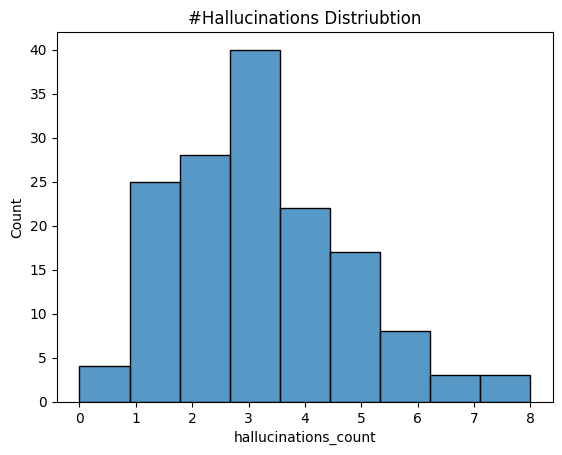

In [4]:
sns.histplot(data=df, x='hallucinations_count', bins=9)
plt.title("#Hallucinations Distriubtion")

Text(0.5, 1.0, 'First Hallucination normalized Location Distribution')

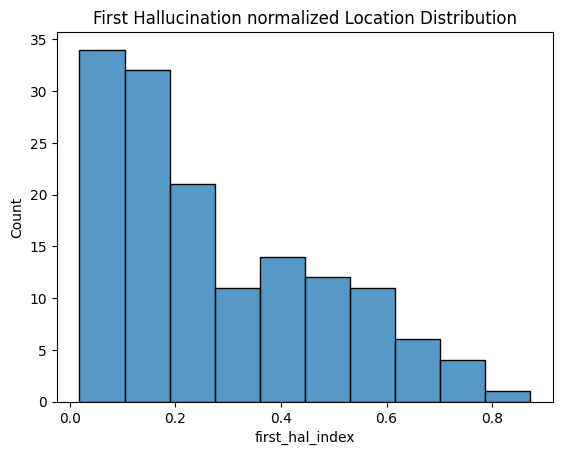

In [8]:
filtered_df = df[df['first_hal_index'] != -1]
sns.histplot(data=filtered_df, x='first_hal_index', bins=10)
plt.title("First Hallucination normalized Location Distribution")

In [9]:
print(pearsonr(df['description_len'], df['hallucinations_count']))
print(pearsonr(df['hedges_count'], df['hallucinations_count']))

PearsonRResult(statistic=np.float64(0.2927831185409878), pvalue=np.float64(0.00027706021284601347))
PearsonRResult(statistic=np.float64(0.09395551276018249), pvalue=np.float64(0.25278091444363826))


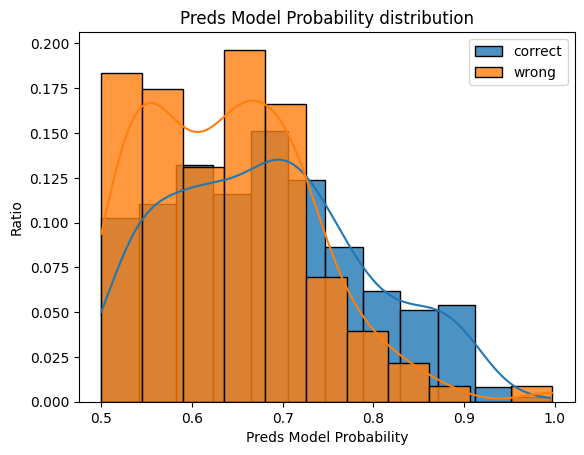

In [10]:
new_data = {
    'probe_number': [],
    'pred': [],
    'label': [],
    'prob': []
}

# Loop through each column group and append to new_data
for i in range(1, 5):
    new_data['probe_number'].extend([i] * len(df))
    new_data['pred'].extend(df[f'pred_{i}'])
    new_data['label'].extend(df[f'label_{i}'])
    new_data['prob'].extend(df[f'pred_{i}_prob'])

# Create the new DataFrame
new_df = pd.DataFrame(new_data)
new_df['correct_pred'] = (new_df['pred'] == new_df['label']).astype(int)
correct_df = new_df[new_df['correct_pred'] == 1]
wrong_df = new_df[new_df['correct_pred'] == 0]

sns.histplot(data=correct_df, x="prob", kde=True, stat='probability', label="correct", alpha=0.8)
sns.histplot(data=wrong_df, x="prob", kde=True, stat='probability', label="wrong", alpha=0.8)
plt.legend()
plt.xlabel('Preds Model Probability')
plt.ylabel('Ratio')
plt.title("Preds Model Probability distribution")
plt.show()

In [5]:
def map_words_logits(logits, description):
    pattern = r'<0x0A>|</s>'
    cleaned_description = re.sub(pattern, ' ', description)
    cleaned_description = re.sub(r'\s+', ' ', cleaned_description).strip()
    words = cleaned_description.split(" ")
    words_logits_indices = []
    idx = 0 
    words_token = ""
    idx_list = []
    flag = False
    for i, (token, prob_dict) in enumerate(logits):
        if ">" == token[-1]:
            flag = False
            continue
        if "<" in token:
            flag = True
        if flag:
            continue
        
        if token.strip() == ".":
            continue
        if words[idx][-1] == "." and token.strip()[-1] != ".":
            word = words[idx][:-1]
        else:
            if "." in words[idx]: 
                print(words[idx])
            word = words[idx]
        # print(i, idx, token.strip(), word, words_token)
        if token.strip() == word:
            words_logits_indices.append((word.replace(".", ""), [i]))
            idx += 1 
        else:
            words_token += token.strip()
            idx_list.append(i)
            if words_token == word:
                words_logits_indices.append((word.replace(".", ""), idx_list))
                words_token = ""
                idx_list = []
                idx += 1 
    return words_logits_indices


def get_in_out_indices(sentences, demo=False):
    random.seed(42)
    results = []
    for sentence in sentences:
        in_indices = []
        out_indices = []
        words = sentence.split()
        in_brackets = False
        for i, word in enumerate(words):
            if '[' in word:
                in_brackets = True
            if ']' in word:
                in_brackets = False

            if in_brackets or '[' in word or ']' in word:
                in_indices.append(i)
            else:
                out_indices.append(i)
        if not demo: 
            results.append({'in': in_indices, 'out': out_indices})
        else:
            random_in_indices = random.sample(range(len(words)), len(in_indices))
            random_out_indices = list(set(range(len(words))) - set(random_in_indices))
            results.append({'in': random_in_indices, 'out': random_out_indices})
    return results


def extract_hals_probs(logits, words_logits_mapping, hallucinations, demo=False):
    pattern = r'<0x0A>|</s>'
    cleaned_hallucinations = re.sub(pattern, ' ', hallucinations)
    cleaned_hallucinations = re.sub(r'\s+', ' ', cleaned_hallucinations).strip()
    sentences = cleaned_hallucinations.split(".")[:-1]
    in_out_probs_list = []
    counter = 0 
    in_out_indices = get_in_out_indices(sentences, demo=demo)
    for in_out_dict, sentence in zip(in_out_indices, sentences): 
        words = sentence.split()
        sentence_dict = {"out": {"min": None, "max": None, "mean": None, "median": None}, "in": {"min": None, "max": None, "mean": None, "median": None}}
        # in part 
        in_indices = in_out_dict['in']
        if len(in_indices) > 0:
            in_probs = []
            for j in in_indices:
                try:
                    word_item = words_logits_mapping[j + counter]
                except:
                    # print(logits)
                    print(sentence)
                    print(words[j])
                    print(words_logits_mapping)
                    print(len(words_logits_mapping), j + counter)
                    return None
                prob_idx = word_item[1][0]
                prob = logits[prob_idx][1][logits[prob_idx][0].strip()]
                in_probs.append(prob)
            
            sentence_dict["in"]["min"] = min(in_probs)
            sentence_dict["in"]["max"] = max(in_probs)
            sentence_dict["in"]["mean"] = sum(in_probs) / len(in_probs)
            sentence_dict["in"]["median"] = statistics.median(in_probs)

        # out part 
        out_indices = in_out_dict['out']
        if len(out_indices) > 0:
            out_probs = []
            for j in out_indices:
                try:
                    word_item = words_logits_mapping[j + counter]
                except:
                    # print(logits)
                    print(sentence)
                    print(words[j])
                    print(words_logits_mapping)
                    print(len(words_logits_mapping), j + counter)
                    return None
                prob_idx = word_item[1][0]
                prob = logits[prob_idx][1][logits[prob_idx][0].strip()]
                out_probs.append(prob)
            
            sentence_dict["out"]["min"] = min(out_probs)
            sentence_dict["out"]["max"] = max(out_probs)
            sentence_dict["out"]["mean"] = sum(out_probs) / len(out_probs)
            sentence_dict["out"]["median"] = statistics.median(out_probs)

        counter += len(words)
        in_out_probs_list.append(sentence_dict)
    return in_out_probs_list

In [6]:
df['words_logits_mapping'] = df.apply(lambda row: map_words_logits(row['logits'], row['description']), axis=1)
df['in_out_probs'] = df.apply(lambda row: extract_hals_probs(row['logits'], row['words_logits_mapping'], row['hallucinations']), axis=1)
df['in_out_random_probs'] = df.apply(lambda row: extract_hals_probs(row['logits'], row['words_logits_mapping'], row['hallucinations'], demo=True), axis=1)

coffee).


In [7]:
def get_probs(in_out_probs):
    res_dict = {"min": [], "max": [], "mean": [], "median": []}
    for probs_dict in in_out_probs:
        if None in list(probs_dict.values())[0].values() or None in list(probs_dict.values())[1].values():
            continue
        res_dict["min"].append(np.log(probs_dict['out']['min']) / np.log(probs_dict['in']['min']))
        res_dict["max"].append(np.log(probs_dict['out']['max']) / np.log(probs_dict['in']['max']))
        res_dict["mean"].append(np.log(probs_dict['out']['mean']) / np.log(probs_dict['in']['mean']))
        res_dict["median"].append(np.log(probs_dict['out']['median']) / np.log(probs_dict['in']['median']))
    return res_dict


def get_probs_by_name(in_out_probs, name):
    res_dict = {"min": [], "max": [], "mean": [], "median": []}
    for probs_dict in in_out_probs:
        if None in list(probs_dict.values())[0].values() or None in list(probs_dict.values())[1].values():
            continue
        res_dict["min"].append(probs_dict[name]['min'])
        res_dict["max"].append(probs_dict[name]['max'])
        res_dict["mean"].append(probs_dict[name]['mean'])
        res_dict["median"].append(probs_dict[name]['median'])
    return res_dict

df['in_out_pairs_ratio_probs'] = df['in_out_probs'].apply(get_probs)
df['out_probs'] = df['in_out_probs'].apply(lambda x: get_probs_by_name(x, "out"))
df['in_probs'] = df['in_out_probs'].apply(lambda x: get_probs_by_name(x, "in"))
df['out_random_probs'] = df['in_out_random_probs'].apply(lambda x: get_probs_by_name(x, "out"))
df['in_random_probs'] = df['in_out_random_probs'].apply(lambda x: get_probs_by_name(x, "in"))

/tmp/ipykernel_8737/1122552129.py:6: RuntimeWarning: divide by zero encountered in log
  res_dict["min"].append(np.log(probs_dict['out']['min']) / np.log(probs_dict['in']['min']))


In [8]:
def statistical_test(agg_metric, df, temps, demo=False):
    if demo:
        col_suffix = "random_probs"
    else:
        col_suffix = "probs"
    unified_in_dict = {"min": [], "max": [], "mean": [], "median": []}
    unified_out_dict = {"min": [], "max": [], "mean": [], "median": []}
    df_temp = df[df['temperature'].isin(temps)]
    for index, row in df_temp.iterrows():
        for key in unified_in_dict.keys():
            unified_in_dict[key].extend(row[f'in_{col_suffix}'][key])
            unified_out_dict[key].extend(row[f'out_{col_suffix}'][key])
    
    metric_in_list = unified_in_dict[agg_metric]
    metric_out_list = unified_out_dict[agg_metric]
    stat, p_value = stats.wilcoxon(metric_in_list, metric_out_list)
    print(f"Statistic: {stat}, p-value: {p_value}")

    data = pd.DataFrame({'In': metric_in_list, 'Out': metric_out_list})
    data_melted = data.melt(var_name='Type', value_name='Probability')
    sns.boxplot(x='Type', y='Probability', data=data_melted)
    plt.title(f"{agg_metric} probabilities inside and outside the hallucinations")
    plt.show()


Statistic: 765.0, p-value: 7.704220254143151e-58


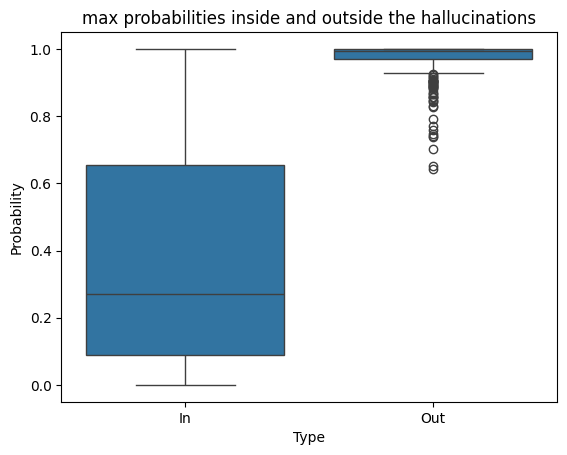

In [17]:
statistical_test(agg_metric="max", df=df, temps=[0.8, 0.9, 1])

Statistic: 2891.5, p-value: 1.5397913557806562e-50


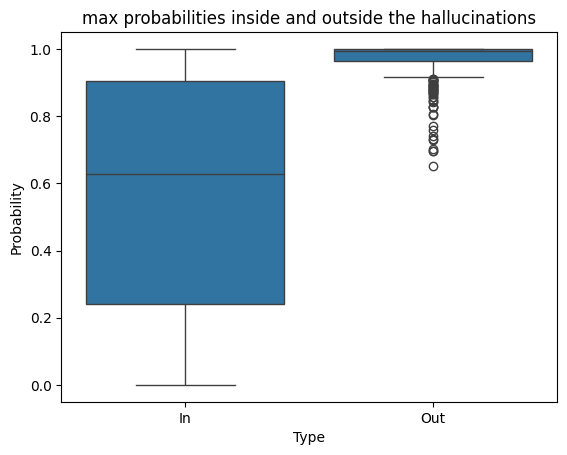

In [18]:
statistical_test(agg_metric="max", df=df, temps=[0.8, 0.9, 1], demo=True)

Statistic: 12425.0, p-value: 5.209838222915902e-24


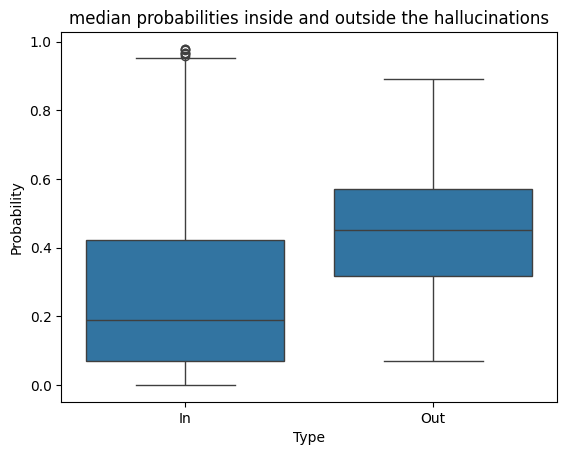

In [145]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1])

Statistic: 29202.0, p-value: 0.11421800907268449


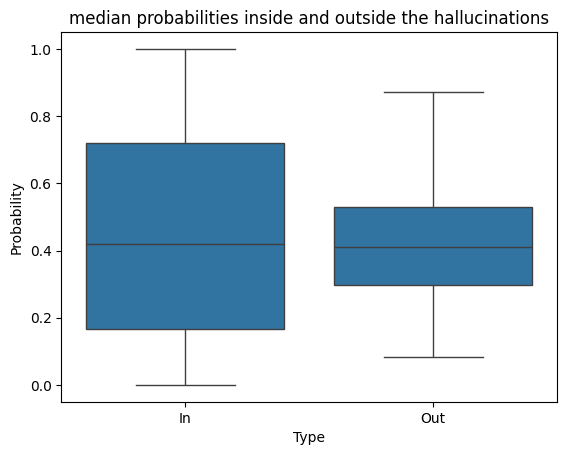

In [146]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1], demo=True)